# Analysis using Malawi

## Packages

In [9]:
import os
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import time

from collections import defaultdict
from glob import glob
import random as rd
import pylab as pl
import pandas as pd
import re
from sklearn import decomposition
from sklearn import pipeline


from PIL import Image
import PIL.ImageOps

#from skimage import io, color
import matplotlib.image as mpimg
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report, mean_squared_error

import seaborn as sns
from sklearn.metrics import confusion_matrix

import pygeos
import ntpath
import geopandas as gpd
#import geoplot
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg
import math


/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
#allow your container to understand gpu errors from the system 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_HOME'] = '/workspace/cache'

In [3]:
#change GPU
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES= 0,1,2,3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


## Import and transform images

In [4]:
# set the random seed for reproducibility
rd.seed(3)

In [5]:
#data_size = int(input("Please input an integer (maybe like 300)"))


In [6]:
#get all the pathlinks to the images
raw_images_links = glob("image_data/malawi_archive/images/*")

In [7]:
#transform the images into arrays
malawi_arrays = [np.array(Image.open(file_name)) for file_name in raw_images_links]
malawi_arrays[0].shape

(256, 256, 4)

In [8]:
#test for identity:
def is_arr_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if elem is myarr), False)

In [9]:
"""## New try
malawi_unique = []
unique_indices = []
for id, file_name in enumerate(raw_images_links):
    im_array = np.array(Image.open(file_name))

    if id == 0:
        malawi_unique.append(im_array)
        unique_indices.append(id)

    if is_arr_in_list(im_array, malawi_unique) == False:
        malawi_unique.append(im_array)
        unique_indices.append(id)"""

'## New try\nmalawi_unique = []\nunique_indices = []\nfor id, file_name in enumerate(raw_images_links):\n    im_array = np.array(Image.open(file_name))\n\n    if id == 0:\n        malawi_unique.append(im_array)\n        unique_indices.append(id)\n\n    if is_arr_in_list(im_array, malawi_unique) == False:\n        malawi_unique.append(im_array)\n        unique_indices.append(id)'

In [10]:
#flatten the data and resize if necessary

#resize the data and flatten it
def transform(dataset):
    new_list = []
    for i in range(len(dataset)):
        #resize the image
        temp2 = resize(dataset[i], (256, 256), Image.NEAREST)
        
        #flatten it
        new_list.append(temp2.flatten())

    return new_list

#do this for malawi
malawi_transform = transform(malawi_arrays)

In [11]:
malawi_transform[0].shape

(262144,)

In [ ]:
n_samples = 50
n_comps_filter =20
pca_filter = PCA(n_comps_filter)
pca_filter.fit(rd.sample(malawi_transform, n_samples))
print(f"Completed training the PCA for filtering with {n_samples} samples and {n_comps_filter} components. \nvar expl: {round(np.cumsum(pca_filter.explained_variance_ratio_)[n_comps_filter-1]*100)}%")
malawi_pca_filter = pca_filter.transform(malawi_transform)

Completed training the PCA for filtering with 50 samples and 20 components. 
var expl: 92%


In [ ]:
malawi_unique, unique_indices = np.unique(malawi_pca_filter, axis= 0, return_index= True)

In [ ]:
#malawi_filtered = pca_filter.inverse_transform(malawi_unique)

In [ ]:
#scale the data using StandardScaler
#StandarScaler normalies the images by subtracting the mean and dividing by the unit variance. 
def return_scaled(input_array):
    scaler = StandardScaler(copy=False)
    scaler.fit(rd.sample(input_array,1000))
    data_set = scaler.fit_transform(input_array)

    return data_set

In [ ]:
"""stages = []
assemblerInputs = malawi_transform
assemblerInputs = [column for column in assemblerInputs if column not in columns_to_remove_from_assembler]
#add vector assembler
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_nonscaled")
stages += [assembler]

col_scaler = StandardScaler(inputCol='features_nonscaled', outputCol='features',withStd=True, withMean=False)
stages += [col_scaler]

pipeline = Pipeline(stages = stages)
assemblerModel = pipeline.fit(df)"""

## Merging the image data with the outcome data

In [ ]:
# Get the location of the images 
image_geodf = gpd.GeoDataFrame() # Create an empty geopandas GeoDataFrame
for i in unique_indices:
    #extract an array of the geo points from the file name 
    point_array = [float(point) for point in str.split(ntpath.basename(raw_images_links[i][:-4]),"_")]

    lat_i = 1
    long_i = 0
    #calculate the width of the image taken
    #https://wiki.openstreetmap.org/wiki/Zoom_levels 
    meters = 40075016.686 * math.cos(math.radians(point_array[lat_i]))/(2**14)

    #the tiles are x-meters wide. Let's find that in degrees: 
    # (https://stackoverflow.com/questions/25237356/convert-meters-to-decimal-degrees)
    width_deg_half = (meters / (111.32 * 1000 * math.cos(point_array[lat_i] * (math.pi / 180))))/2

    geo_point = [(point_array[lat_i] - width_deg_half, point_array[long_i]+ width_deg_half),
                (point_array[lat_i] + width_deg_half, point_array[long_i]+ width_deg_half),
                (point_array[lat_i] + width_deg_half, point_array[long_i] - width_deg_half),
                (point_array[lat_i] - width_deg_half, point_array[long_i] - width_deg_half)]

    # Create a Shapely polygon from the coordinate-tuple list
    image_geodf.loc[i, 'geometry'] = Polygon(geo_point)
    # assign an image id. used for merging with actual images and the survey values
    image_geodf.loc[i, 'image_id'] = i  

    # Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
image_geodf.crs = from_epsg(4326)

In [ ]:
#load outcome data
outcome_geodf = gpd.read_file("outcome_data/ml_gdf.shp")

In [ ]:
#have a look 
outcome_geodf.head()

In [ ]:
import geopandas

In [ ]:
#merge based on whether an image contains the point 
geo_df = geopandas.sjoin(image_geodf, outcome_geodf, how="inner", op = "contains")

In [ ]:
#look at the merged geodata frame
geo_df.head()

In [ ]:
# Create plot
ax = image_geodf.plot(facecolor='grey')
outcome_geodf.plot(ax=ax, color='blue', markersize = .001, alpha = 0.2)
plt.tight_layout()

In [ ]:
### peak into the data

n_col = 5
n_row = 4
## show the original images
plt.figure(figsize=(2. * n_col, 2.26 * n_row))
plt.suptitle('Original photos', size=16)

#loop through some random images
for i, comp in enumerate(malawi_transform[:n_col*n_row]):
    plt.subplot(n_col, n_row, i + 1)
    #comp = scaler.inverse_transform(comp)
    comp = (comp * 255).astype(np.uint8)
    plt.imshow(comp.reshape(256,256,4))
    plt.title(i)
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [ ]:
#Create plot wiht Malawi outline
"""world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres'))
ax = geoplot.polyplot(image_geodf, color = 'grey')
geoplot.polyplot(world.query('name == "Malawi"'), ax = ax)
outcome_geodf.plot(markersize = 0.01, alpha = 0.2, ax = ax)"""

In [ ]:
## Select a single image by it's ID to be printed
comp = malawi_transform[1]
#comp = scaler.inverse_transform(comp)
plt.figure()
plt.subplot(1, 2, 1)
comp = (comp * 255).astype(np.uint8)
plt.imshow(comp.reshape(256,256,4))

comp = malawi_transform[1784]
plt.subplot(1, 2, 2)
comp = (comp * 255).astype(np.uint8)
plt.imshow(comp.reshape(256,256,4))

In [ ]:
# check for duplicates 

print(raw_images_links[1])
print(raw_images_links[1784])


np.mean(np.asarray(Image.open(raw_images_links[1])) == np.asarray(Image.open(raw_images_links[1784])))

## Assemble Data Set

In [ ]:
#make empty lists
X_full = []
Y_full = []
#fill them with the image data and the outcome data
for i in range(len(geo_df)):
    obs = geo_df.iloc[i]
    X_full.append(malawi_transform[int(obs['image_id'])])
    Y_full.append(obs['hv271'])

In [ ]:
#split into train and test data set
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.15)

In [ ]:
len(np.unique(y_train))

## PCA


In [ ]:
# Let's find how many components we should use by just applying a PCA with a range of components

#initialize the pca
pca = PCA(whiten=True, copy=True, random_state= 10)
#fit it
pca.fit(rd.sample(X_train,100))

#get the cumulative 
total = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
total[26]

In [1]:
plt.figure(figsize=(15, 10))
comp_to_view = 25
#let's plot it
plot_xs = list(range(comp_to_view))


plt.scatter(plot_xs, pca.explained_variance_ratio_[:comp_to_view], color='black', label='Explained variance proportion')
plt.scatter(plot_xs, total[:comp_to_view],color='orange', label='Total')

plt.legend(loc=2)
plt.xlabel('Number of Component', size=16)
plt.ylabel('Variance Explained (%)', size=16)
#plt.hlines(0.,xmin=0, xmax=comp_to_view, colors = 'blue', linestyles='--')
plt.grid('minor')
plt.show()

print(pca.explained_variance_ratio_[:comp_to_view])

NameError: name 'plt' is not defined

In [60]:
#initialize the pca

n_comp = 25
pca = PCA(n_components = n_comp, whiten=True, copy=True, random_state= 10)

#fit with random sample of _ observations
pca.fit(rd.sample(X_train,1000))


PCA(n_components=25, random_state=10, whiten=True)

In [61]:
pca.components_.shape

(25, 262144)

In [62]:
## batchwise transformation of the 

reduced = []
batchsize = 2500
# 
for i in range(0, len(X_train), batchsize):
    if i == 0:
        reduced = pca.transform(X_train[i:i+batchsize])
        continue 
    
    reduced_batch = pca.transform(X_train[i:i+batchsize])
    reduced = np.concatenate((reduced, reduced_batch), axis =0)


In [63]:
# Ideas from Will
# Kernel Trick 
# Random Projection
# IRLS (iterarated reweighted)

In [64]:
X_train_pca = np.asarray(reduced)
n_obs = len(X_train_pca)

In [65]:
pd.DataFrame(X_train_pca, y_train).to_csv("train_set_pca.csv")

In [66]:
len(np.unique(X_train_pca[:,1]))
len(np.unique(y_train))

11150

In [67]:
import matplotlib.image as mpimg
#function straight copied from
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap_p=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        #print(vmax)
        plt.imshow((comp*255).astype(np.uint8),
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax 
                   #cmap = cmap_p
                   )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [68]:
eigenimages = pca.components_.reshape(25,256,256,4).copy()
"""#eigenimages[:,:,:,-1] += .5
eigenimages[:,:,:,0] += np.mean(eigenimages[:,:,:,0])
eigenimages[:,:,:,1] += np.mean(eigenimages[:,:,:,1])
eigenimages[:,:,:,2] += np.mean(eigenimages[:,:,:,2])"""


'#eigenimages[:,:,:,-1] += .5\neigenimages[:,:,:,0] += np.mean(eigenimages[:,:,:,0])\neigenimages[:,:,:,1] += np.mean(eigenimages[:,:,:,1])\neigenimages[:,:,:,2] += np.mean(eigenimages[:,:,:,2])'

In [69]:
np.mean(eigenimages[:,:,:,2])

3.973359796885341e-05

In [70]:
plot_gallery("PCA", eigenimages[:,:,:,:3], n_col=5, n_row=5, cmap_p = plt.cm.viridis)

# Models

In [71]:
# linear regression with full un-PCAed data blows up the kernel
# DO NOT RUN WITH EXTRA DATA
lin_model = LinearRegression()
lin_model.fit(X_train_pca, y_train)

LinearRegression()

In [72]:
lin_model.score(X_train_pca, y_train)

0.03143548281893427

In [73]:
len(np.unique(X_train_pca))

12130

In [74]:
plt.hist((y_train))

(array([2883., 4362., 2136., 1303.,  999.,  761.,  640.,  437.,  282.,
          74.]),
 array([-122719. ,  -70784.6,  -18850.2,   33084.2,   85018.6,  136953. ,
         188887.4,  240821.8,  292756.2,  344690.6,  396625. ]),
 <BarContainer object of 10 artists>)

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
rf = RandomForestRegressor(n_estimators= 100, bootstrap = True)
rf.fit(X_train_pca, y_train)

RandomForestRegressor()

In [77]:
rf.score(X_train_pca, y_train)

0.511687101947754

## Running Grid Search on Random Forest Regressor

Source and documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Tuning: 
- n_estimators: number of trees in the forest
- max_depth: maximum depth of the tree 
- max_features: number of features taken into account when splitting. 

In [78]:
hyper_n_list = [100]
hyper_depth_list = [1,2,3,4,5, 10,16,18,20,22,24,26, 30, 40, 50, 100, 200]
hyper_m_list = ["auto", "sqrt", "log2"]

In [79]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators':[100],
                              'max_depth': hyper_depth_list,
                              'max_features': hyper_m_list,
                            },cv=4, scoring="r2",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_train_pca,y_train)

Fitting 4 folds for each of 51 candidates, totalling 204 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 16, 18, 20, 22, 24,
                                       26, 30, 40, 50, 100, 200],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100]},
             scoring='r2', verbose=1)

In [80]:
cv_df = pd.DataFrame(grid_search.cv_results_)

In [81]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.644555,0.035414,0.007870,0.000142,1,auto,100,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.048964,0.030840,0.031855,0.027322,0.034745,0.008380,51
1,0.240566,0.013707,0.008156,0.000208,1,sqrt,100,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.041466,0.034192,0.036732,0.034858,0.036812,0.002844,49
2,0.207364,0.001025,0.008246,0.000147,1,log2,100,"{'max_depth': 1, 'max_features': 'log2', 'n_es...",0.040072,0.032951,0.035454,0.033326,0.035451,0.002834,50
3,1.109759,0.021557,0.009499,0.000315,2,auto,100,"{'max_depth': 2, 'max_features': 'auto', 'n_es...",0.091548,0.068843,0.071177,0.062278,0.073462,0.010940,48
4,0.349374,0.010830,0.009933,0.000266,2,sqrt,100,"{'max_depth': 2, 'max_features': 'sqrt', 'n_es...",0.085829,0.070998,0.078749,0.072455,0.077007,0.005867,46
5,0.302731,0.009610,0.009726,0.000200,2,log2,100,"{'max_depth': 2, 'max_features': 'log2', 'n_es...",0.084441,0.068694,0.074985,0.071022,0.074785,0.006011,47
6,1.577747,0.007671,0.011729,0.000400,3,auto,100,"{'max_depth': 3, 'max_features': 'auto', 'n_es...",0.155516,0.118700,0.126865,0.112003,0.128271,0.016587,43
7,0.441595,0.024711,0.011324,0.000235,3,sqrt,100,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.140247,0.116695,0.127806,0.118533,0.125820,0.009334,44
8,0.376466,0.018628,0.011410,0.000223,3,log2,100,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.134051,0.109755,0.122321,0.113631,0.119940,0.009332,45
9,2.057587,0.039894,0.014929,0.000140,4,auto,100,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.228230,0.177709,0.189592,0.169711,0.191311,0.022459,40


In [82]:
len(cv_df)

51

In [83]:
for param_max_feature in hyper_m_list:
    plt.plot('param_max_depth','mean_test_score',label = param_max_feature, data = cv_df[cv_df["param_max_features"]== param_max_feature])
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Mean R^2")
    plt.legend()

In [84]:
def hyperparam_plot2d(df, param, outcome, group_var = None):

    '''
    func: function to plot the performance of a parameter
    - df (dataframe): cross-validation grid search dataframe

    params have to be column names in DF
    - param (str): which parameter to asses
    - outcome (str): which outcome to find the max for
    - group_var (str): grouping variable (default None)
    '''

    group_var_list = np.unique(np.array(df[group_var]))
    plt.figure(figsize=(12,8))
    #print(np.argmax(np.asarray(df[outcome])))
    best_score = np.max(np.asarray(df[outcome]))
    best_score_param = np.asarray(df[param])[np.argmax(np.asarray(df[outcome]))]
    if group_var != None:
        best_score_group = np.asarray(df[group_var])[np.argmax(np.asarray(df[outcome]))]
        #print(best_score_group)

    if group_var == None:
        plt.plot(param,outcome,data = df)
        plt.xlabel(param)
        plt.ylabel(outcome)
        #plt.grid()
        plt.vlines(best_score_param, 0, np.max(np.asarray(df[outcome])+.05))
        plt.text(best_score_param,best_score + .05,  f'Best parameter: {best_score_param} with score: {best_score}',size =12)
        plt.legend()
    else:
        for inst in group_var_list:
            plt.plot(param,outcome,label = inst, data = df[df[group_var]== inst])
            plt.xlabel(param)
            plt.ylabel(outcome)
            #plt.grid()
            plt.text(best_score_param,best_score - .25,  f'Best parameter: {best_score_param} \n with score: {round(best_score,3)} \nin group:{best_score_group}', size = 12)
            plt.vlines(best_score_param, 0, best_score+.05)
            plt.legend(loc = 4)
            plt.ylim(bottom =0 )
    plt.grid()
    return plt.show

In [85]:
hyperparam_plot2d(cv_df, 'param_max_depth', 'mean_test_score', 'param_max_features')

<function matplotlib.pyplot.show(close=None, block=None)>

In [86]:
hyperparam_plot2d(cv_df, 'param_max_features' ,'mean_test_score','param_max_depth')

<function matplotlib.pyplot.show(close=None, block=None)>

In [87]:
best_forest = grid_search.best_estimator_

# Evaluation on Test Set

In [88]:
# We have to apply the same pre-processing by PCA to the test set.
X_test_pca = pca.transform(X_test)
pd.DataFrame(X_test_pca, y_test).to_csv("train_set_pca.csv")

In [89]:
## Linear Regression
lin_model.score(X_test_pca, y_test)

## My interpretation: This model is completely useless because does not attribtue for the non-linearity of the data. 
# The test R^2 being better than train means essentially nothing because the models are so bad.

0.02083859676394717

In [90]:
## Best forest: 
best_forest.score(X_test_pca, y_test)

# This is quite good, given that the best train score of 0.504132 with an SD of like 0.06 so we are not significantly different to that. 

0.48826702479327866

In [91]:
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 18,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

# CNN 

* INPUT
    * reshape back to image format
    * resize? 
    * greyscale
* MODEL
    * Input
    * Convolutional
    * 


Orienting myself on these neat tutorials:
* https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
* https://cs231n.github.io/convolutional-networks/

In [92]:
import tensorflow as tf

In [94]:
print(tf.__version__)

2.8.0


In [95]:
!pip install keras-rectified-adam

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [96]:
from tensorflow import keras
import gc
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

### Reshape the dataset to images again

In [97]:
X_train_cnn = np.asarray(X_train).reshape(n_obs, 256, 256, 4)
#X_train_cnn

In [98]:
X_train_cnn = X_train_cnn[:,:,:,:3].astype('float32') # Taking out the fourth channel as ghe information is the same everywhere

In [99]:
y_train_cnn = np.asarray(y_train).astype('float32')

In [100]:
X_train1_cnn, X_val_cnn, y_train1_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train_cnn, test_size=0.10)

### Model

In [102]:
# https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/

from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [127]:
cnn_satellite = Sequential()
cnn_satellite.add(Conv2D(32, kernel_size=(16, 16),activation='linear',input_shape=(256,256,3),padding='same'))
cnn_satellite.add(LeakyReLU(alpha=0.1))
cnn_satellite.add(MaxPooling2D((2, 2),padding='same'))
cnn_satellite.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
cnn_satellite.add(LeakyReLU(alpha=0.1))
cnn_satellite.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_satellite.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
cnn_satellite.add(LeakyReLU(alpha=0.1))                  
cnn_satellite.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_satellite.add(Flatten())
cnn_satellite.add(Dense(32, activation='linear'))
cnn_satellite.add(LeakyReLU(alpha=0.1))                  
cnn_satellite.add(Dense(1, activation='linear'))

gc.collect()

1678

In [128]:
cnn_satellite.compile(loss=keras.losses.mean_squared_error, 
                      optimizer=keras.optimizers.Adam(),
                      metrics=[coeff_determination])

In [129]:
cnn_satellite.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      24608     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [191]:
## Hyperparameters

epochs = 500
batchsize = 100

In [192]:
"""cnn_history = cnn_satellite.fit(X_train1_cnn, 
                  y_train1_cnn, 
                  batch_size=batchsize, 
                  epochs=epochs, 
                  verbose=1, 
                  validation_data=(X_val_cnn, y_val_cnn))"""

Epoch 1/500
125/125 [==============================] - 76s 578ms/step - loss: 5902403584.0000 - coeff_determination: 0.4911 - val_loss: 6934495232.0000 - val_coeff_determination: 0.3225
Epoch 2/500
125/125 [==============================] - 69s 549ms/step - loss: 5922669568.0000 - coeff_determination: 0.4896 - val_loss: 6523551744.0000 - val_coeff_determination: 0.3727
Epoch 3/500
125/125 [==============================] - 69s 553ms/step - loss: 5872253952.0000 - coeff_determination: 0.4949 - val_loss: 6433839616.0000 - val_coeff_determination: 0.3812
Epoch 4/500
125/125 [==============================] - 69s 554ms/step - loss: 5899567616.0000 - coeff_determination: 0.4906 - val_loss: 6620198400.0000 - val_coeff_determination: 0.3582
Epoch 5/500
125/125 [==============================] - 69s 554ms/step - loss: 5926425600.0000 - coeff_determination: 0.4864 - val_loss: 6439604224.0000 - val_coeff_determination: 0.3841
Epoch 6/500
125/125 [==============================] - 69s 553ms/step 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125/125 [==============================] - 69s 553ms/step - loss: 5792403968.0000 - coeff_determination: 0.4995 - val_loss: 6472448000.0000 - val_coeff_determination: 0.3758
Epoch 131/500
125/125 [==============================] - 69s 554ms/step - loss: 5800313856.0000 - coeff_determination: 0.4991 - val_loss: 6490508800.0000 - val_coeff_determination: 0.3773
Epoch 132/500
125/125 [==============================] - 69s 553ms/step - loss: 5793108480.0000 - coeff_determination: 0.4994 - val_loss: 6479042560.0000 - val_coeff_determination: 0.3760
Epoch 133/500
125/125 [==============================] - 69s 554ms/step - loss: 5806678016.0000 - coeff_determination: 0.4995 - val_loss: 6569068544.0000 - val_coeff_determination: 0.3676
Epoch 134/500
125/125 [==============================] - 69s 554ms/step - loss: 5788085760.0000 - coeff_determination: 0.5000 - val_loss: 6592923648.0000 - val_coeff_determination: 0.3607
Epoch 135/500
125/125 [==============================] - 69s 554ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125/125 [==============================] - 69s 554ms/step - loss: 5766774784.0000 - coeff_determination: 0.5030 - val_loss: 6622508544.0000 - val_coeff_determination: 0.3594
Epoch 251/500
125/125 [==============================] - 69s 553ms/step - loss: 5753712128.0000 - coeff_determination: 0.5034 - val_loss: 6595913216.0000 - val_coeff_determination: 0.3640
Epoch 252/500
125/125 [==============================] - 69s 554ms/step - loss: 5781568512.0000 - coeff_determination: 0.5048 - val_loss: 6534338048.0000 - val_coeff_determination: 0.3677
Epoch 253/500
125/125 [==============================] - 69s 554ms/step - loss: 5762868736.0000 - coeff_determination: 0.5023 - val_loss: 6448770560.0000 - val_coeff_determination: 0.3796
Epoch 254/500
125/125 [==============================] - 69s 554ms/step - loss: 5779975168.0000 - coeff_determination: 0.5000 - val_loss: 6492449280.0000 - val_coeff_determination: 0.3735
Epoch 255/500
125/125 [==============================] - 69s 554ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125/125 [==============================] - 69s 553ms/step - loss: 5758772224.0000 - coeff_determination: 0.5060 - val_loss: 6526941184.0000 - val_coeff_determination: 0.3685
Epoch 367/500
125/125 [==============================] - 69s 553ms/step - loss: 5741861376.0000 - coeff_determination: 0.4994 - val_loss: 6522080256.0000 - val_coeff_determination: 0.3697
Epoch 368/500
125/125 [==============================] - 69s 553ms/step - loss: 5742405632.0000 - coeff_determination: 0.5034 - val_loss: 6395468288.0000 - val_coeff_determination: 0.3885
Epoch 369/500
125/125 [==============================] - 69s 554ms/step - loss: 5744579072.0000 - coeff_determination: 0.5019 - val_loss: 6456019968.0000 - val_coeff_determination: 0.3780
Epoch 370/500
125/125 [==============================] - 69s 554ms/step - loss: 5789431296.0000 - coeff_determination: 0.4987 - val_loss: 6540060672.0000 - val_coeff_determination: 0.3678
Epoch 371/500
125/125 [==============================] - 69s 555ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125/125 [==============================] - 69s 554ms/step - loss: 5759425024.0000 - coeff_determination: 0.5025 - val_loss: 6416269824.0000 - val_coeff_determination: 0.3836
Epoch 486/500
125/125 [==============================] - 69s 555ms/step - loss: 5739545088.0000 - coeff_determination: 0.5029 - val_loss: 6590536704.0000 - val_coeff_determination: 0.3631
Epoch 487/500
125/125 [==============================] - 69s 555ms/step - loss: 5750680576.0000 - coeff_determination: 0.5015 - val_loss: 6592461312.0000 - val_coeff_determination: 0.3638
Epoch 488/500
125/125 [==============================] - 69s 553ms/step - loss: 5748602368.0000 - coeff_determination: 0.5030 - val_loss: 6496378368.0000 - val_coeff_determination: 0.3731
Epoch 489/500
125/125 [==============================] - 69s 555ms/step - loss: 5737216000.0000 - coeff_determination: 0.5060 - val_loss: 6652797952.0000 - val_coeff_determination: 0.3550
Epoch 490/500
125/125 [==============================] - 69s 554ms/step - 

In [193]:
test_eval = cnn_satellite.evaluate(X_val_cnn, y_val_cnn, verbose=1)

44/44 [==============================] - 1s 14ms/step - loss: 6399974400.0000 - coeff_determination: 0.3256


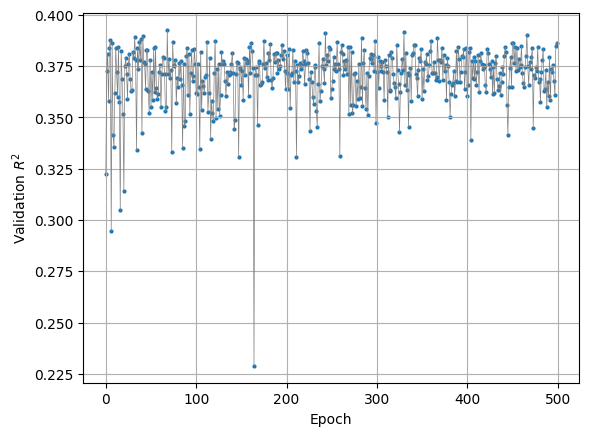

In [198]:
plt.plot([i for i in range(epochs)], cnn_history.history['val_coeff_determination'], 
         color = 'grey',
        lw = .5)
plt.scatter([i for i in range(epochs)], 
            cnn_history.history['val_coeff_determination'],
            s=4)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation $R^2$')
plt.show()

In [235]:
#cnn_satellite.save('cnn_malawi_500epochs')

INFO:tensorflow:Assets written to: cnn_malawi_500epochs/assets


## ResNet50

Cite
https://arxiv.org/abs/1603.05027

@misc{https://doi.org/10.48550/arxiv.1603.05027,
  doi = {10.48550/ARXIV.1603.05027},
  
  url = {https://arxiv.org/abs/1603.05027},
  
  author = {He, Kaiming and Zhang, Xiangyu and Ren, Shaoqing and Sun, Jian},
  
  keywords = {Computer Vision and Pattern Recognition (cs.CV), Machine Learning (cs.LG), FOS: Computer and information sciences, FOS: Computer and information sciences},
  
  title = {Identity Mappings in Deep Residual Networks},
  
  publisher = {arXiv},
  
  year = {2016},
  
  copyright = {arXiv.org perpetual, non-exclusive license}
}


In [269]:
from tensorflow.keras import applications

In [270]:
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None
)

In [271]:
resnet.trainable = False

In [272]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_12[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

                                                                                                  
 conv2_block2_out (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, None, None,   1024       ['conv2_block2_out[0][0]']       
 ormalization)                  256)                                                              
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, None, None,   0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        256)                                                              
                                                                                                  
 conv2_blo

                                128)                             ]                                
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block2_1_relu[0][0]']    
 g2D)                           128)                                                              
          

 conv3_block4_2_relu (Activatio  (None, None, None,   0          ['conv3_block4_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, None, None,   0          ['conv3_block3_out[0][0]']       
 )                              512)                                                              
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block4_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block4_out (Add)         (None, None, None,   0           ['max_pooling2d_16[0][0]',       
          

                                                                                                  
 conv4_block3_preact_relu (Acti  (None, None, None,   0          ['conv4_block3_preact_bn[0][0]'] 
 vation)                        1024)                                                             
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block3_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block3_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, None, None,   0          ['conv4_block5_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block5_2_relu[0][0]']    
                                1024)                                                             
          

 conv5_block1_out (Add)         (None, None, None,   0           ['conv5_block1_0_conv[0][0]',    
                                2048)                             'conv5_block1_3_conv[0][0]']    
                                                                                                  
 conv5_block2_preact_bn (BatchN  (None, None, None,   8192       ['conv5_block1_out[0][0]']       
 ormalization)                  2048)                                                             
                                                                                                  
 conv5_block2_preact_relu (Acti  (None, None, None,   0          ['conv5_block2_preact_bn[0][0]'] 
 vation)                        2048)                                                             
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, None, None,   1048576     ['conv5_block2_preact_relu[0][0]'
          

In [277]:
inputs = keras.Input(shape=(256, 256, 3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = resnet(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='linear')(x)
#x = keras.layers.Dropout(.2)(x)
#x = keras.layers.LeakyReLU(alpha=0.1)(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = 'linear')(x)

model = keras.Model(inputs, outputs)

In [278]:
X_cnn_res50 = applications.resnet_v2.preprocess_input(
    X_train1_cnn)

#X_cnn_res50_val = applications.resnet_v2.preprocess_input(
#    X_train1_cnn)

In [279]:
model.compile(loss=keras.losses.mean_squared_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=[coeff_determination])

In [281]:
resnet_history = model.fit(X_cnn_preped, 
          y_train1_cnn, 
          epochs=150,
          batch_size = 75 
          #,callbacks=...
          #,validation_data= (X_cnn_res50_val, y_val_cnn)
         )

Epoch 1/150
167/167 [==============================] - 10s 48ms/step - loss: 12132400128.0000 - coeff_determination: -0.0376
Epoch 2/150
167/167 [==============================] - 8s 49ms/step - loss: 12119429120.0000 - coeff_determination: -0.0351
Epoch 3/150
167/167 [==============================] - 8s 50ms/step - loss: 12097121280.0000 - coeff_determination: -0.0314
Epoch 4/150
167/167 [==============================] - 8s 50ms/step - loss: 12066774016.0000 - coeff_determination: -0.0320
Epoch 5/150
167/167 [==============================] - 8s 50ms/step - loss: 12032739328.0000 - coeff_determination: -0.0261
Epoch 6/150
167/167 [==============================] - 8s 50ms/step - loss: 11997116416.0000 - coeff_determination: -0.0244
Epoch 7/150
167/167 [==============================] - 8s 49ms/step - loss: 11963144192.0000 - coeff_determination: -0.0206
Epoch 8/150
167/167 [==============================] - 8s 49ms/step - loss: 11932553216.0000 - coeff_determination: -0.0186
Epoch 9

167/167 [==============================] - 8s 50ms/step - loss: 11835689984.0000 - coeff_determination: -0.0133
Epoch 132/150
167/167 [==============================] - 8s 50ms/step - loss: 11835680768.0000 - coeff_determination: -0.0130
Epoch 133/150
167/167 [==============================] - 8s 51ms/step - loss: 11835880448.0000 - coeff_determination: -0.0157
Epoch 134/150
167/167 [==============================] - 8s 50ms/step - loss: 11835700224.0000 - coeff_determination: -0.0148
Epoch 135/150
167/167 [==============================] - 8s 50ms/step - loss: 11835710464.0000 - coeff_determination: -0.0151
Epoch 136/150
167/167 [==============================] - 8s 50ms/step - loss: 11835788288.0000 - coeff_determination: -0.0174
Epoch 137/150
167/167 [==============================] - 8s 50ms/step - loss: 11835694080.0000 - coeff_determination: -0.0149
Epoch 138/150
167/167 [==============================] - 8s 50ms/step - loss: 11835745280.0000 - coeff_determination: -0.0139
Epoch 

In [280]:
gc.collect()

22772

In [ ]:
plt.plot([i for i in range(150)], resnet_history.history['coeff_determination'], color = 'grey')
plt.scatter([i for i in range(150)], resnet_history.history['coeff_determination'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation $R^2$')
plt.show()

## Heatmapping

Load model and hope it works

In [8]:
malawi_model = keras.models.load_model('cnn_malawi_500epochs')

NameError: name 'keras' is not defined

In [7]:
resnet_history.summary()

NameError: name 'resnet_history' is not defined

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from tensorflow.keras import models

import tensorflow as tf
import numpy as np

image_size = 224

# Load pre-trained Keras model and the image to classify
model = cnn_satellite
image = np.random.random((image_size, image_size, 3))
img_tensor = preprocessing.image.img_to_array(image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

conv_layer = model.get_layer("block5_conv3")
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

## Support Vector Regressor

In [1]:
from sklearn.svm import SVR

In [2]:
svr = SVR()

In [5]:
svr.fit(X_train_pca, y_train_pca)

NameError: name 'X_train_pca' is not defined

In [4]:
tf.keras.utils.plot_model(
    cnn_satellite,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

NameError: name 'tf' is not defined